Mohcen AOUADJ  
AUGUST 2022   
Batna, ALGERIA  



This project has purpose of chest cancer detection using different CNN technics. The algorithm is supposed to be able to diagnose if the case have cancer and if yes which type (Classification)

## Convolution Neural Networks

- CNN are based on multi-layer neural network, with convolutional layers interspersed with pooling (sub-sampling) layers and then followed by fully connected layers.
- Unlike the conventional MLNN, a CNN exploits extensive weight-sharing to reduce the degrees of freedom of models. 
- A pooling layer helps reduce computation time and gradually build up spatial and configural invariance.
- Such configuration is utilized in order to take 2D and 3D images as inputs to prevent the destruction of the structural and configural information.  

![Convolutional Neural Network](https://ars.els-cdn.com/content/image/1-s2.0-S0939388918301181-gr2.jpg){align="center"}


In this project we are going to start the modeling of our solution by the basic CNN model inspired by the AlexNet famous paper, then we pass to more complicated CNN models like RESNET50 and VGG15.

Technology used :
- Tensorflow.


### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
import PIL
import PIL.Image
from skimage.feature import hog
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import resnet, ResNet50

from tensorflow.keras.utils import plot_model
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Data Loading

In [2]:
def ResizeAndConvert(img):
    im = cv.medianBlur(img.astype(np.uint8),5)
    #R, G, B = cv.split(im)
    #Y = 0.299*R + 0.587*G + 0.114*B
    #Y = resize(Y, (64,128))
    #Cb = -0.1687*R -0.3313*G + 0.5*B + 128
    #Cb = resize(Cb, (64,128))
    #Cr = 0.5*R - 0.4187*G - 0.0813*B + 128
    im = resize(im, (64,128))
    
    #merged_img = cv.merge([Y,Cb,Cr])
    
    fv, hog_image = hog(im.astype(np.uint8), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                        visualize=True, channel_axis = -1)
    
    return fv

In [3]:
def dataset(img_folder):
    image_data = []
    for dirs in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dirs)):
            image_path= os.path.join(img_folder, dirs,  file)
            image= cv.imread( image_path)
            image_data.append(image)
    return np.array(image_data, dtype=object)

In [4]:
train_path = '../input/chest-ctscan-images/Data/train'
images = dataset(train_path)

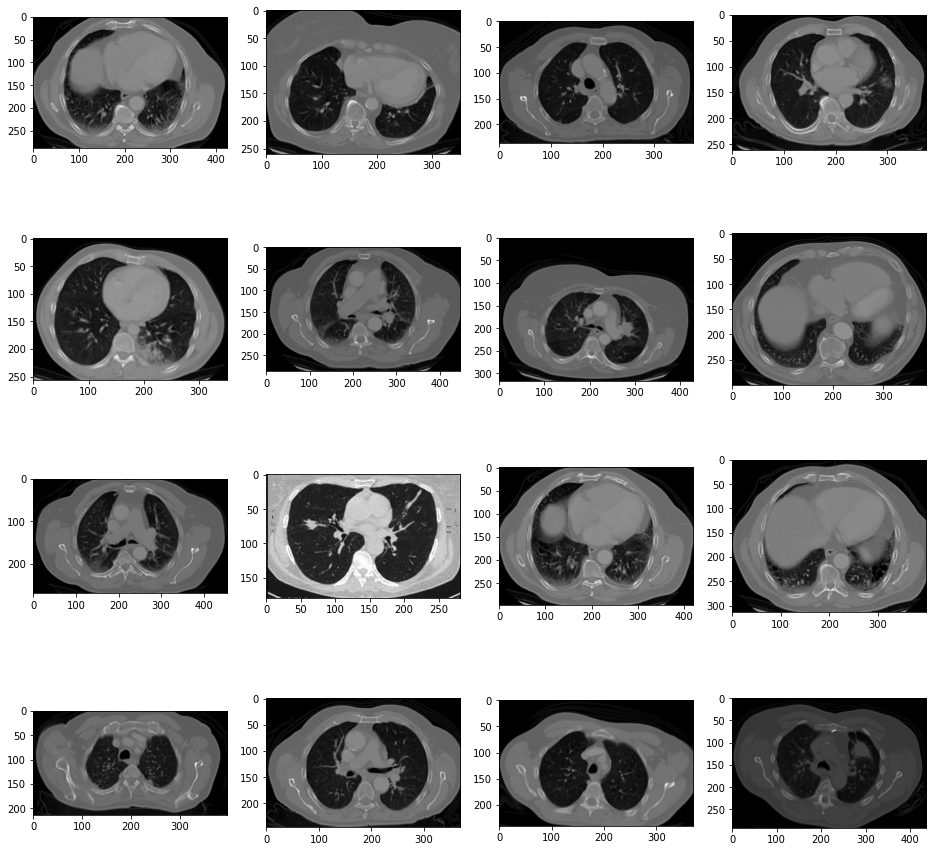

In [5]:
plt.figure(figsize = (16,16))
for i in range(0, 16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i], cmap = "gray")
plt.show()

In [6]:
shapes = []
for i in range(images.shape[0]):
    shapes.append(images[i].shape)


np.array(shapes).mean(axis=0)

array([303.31484502, 435.83686786,   3.        ])

In [7]:
IMAGE_SHAPE = (303, 430)
N_CLASSES = 4
BATCH_SIZE = 32

train_directory = '../input/chest-ctscan-images/Data/train'
val_directory = '../input/chest-ctscan-images/Data/valid'
test_directory = '../input/chest-ctscan-images/Data/test'


train_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,dtype='float32')
train_batchs = train_dataset.flow_from_directory(   
    train_directory,
    class_mode ='categorical',
    batch_size = BATCH_SIZE,
    target_size = IMAGE_SHAPE,
)

test_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,dtype='float32')
test_batchs = test_dataset.flow_from_directory(   
    test_directory,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    target_size = IMAGE_SHAPE,
)

val_dataset = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,dtype='float32')
val_batchs = val_dataset.flow_from_directory(   
    val_directory,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    target_size = IMAGE_SHAPE,
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## 2. Building Classic CNN Model

In [8]:
weight_decay = 1e-3


model = Sequential()
model.add(Conv2D(8, kernel_size = (3,3), activation='relu', padding = 'same',
                 input_shape=(303,430, 3)))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same',
                 kernel_regularizer = regularizers.l2(weight_decay)))

#model.add(MaxPool2D((2,2)))
#model.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding = 'same',kernel_regularizer = regularizers.l2(weight)))

model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

2022-08-09 22:07:04.250803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 22:07:04.400977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 22:07:04.401796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 22:07:04.402966: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 303, 430, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 151, 215, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 151, 215, 64)      4672      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 107, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 107, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 513600)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               1

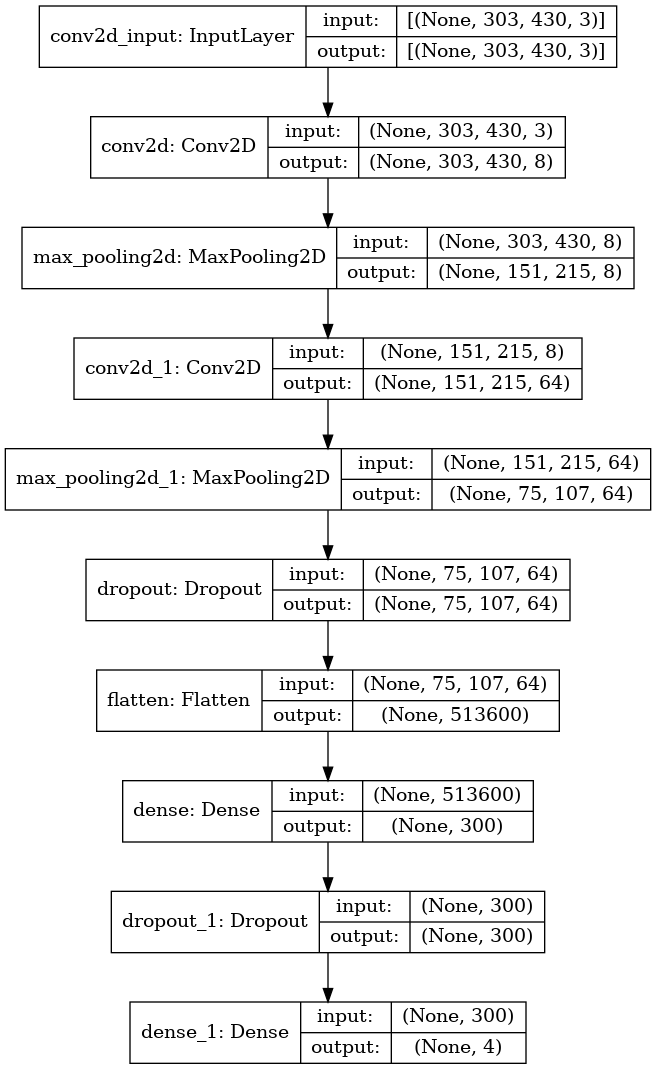

In [10]:
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## 3. Training The Model

In [11]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = optimizers.Adam(learning_rate = 0.001, decay= 1e-5)

In [12]:
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
result = model.fit(train_batchs, 
          steps_per_epoch = 20, 
          epochs = 100, 
          verbose = 1, 
          validation_data = val_batchs, 
          callbacks = [checkpointer, early_stopping]
         )

2022-08-09 22:07:08.735110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-09 22:07:10.511364: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 15s 360ms/step - loss: 4.6211 - accuracy: 0.3409 - val_loss: 1.0194 - val_accuracy: 0.5278

Epoch 00001: val_loss improved from inf to 1.01942, saving model to chestmodel.hdf5
Epoch 2/100
20/20 [==============================] - 7s 339ms/step - loss: 0.8835 - accuracy: 0.6215 - val_loss: 0.8688 - val_accuracy: 0.6111

Epoch 00002: val_loss improved from 1.01942 to 0.86879, saving model to chestmodel.hdf5
Epoch 3/100
20/20 [==============================] - 6s 307ms/step - loss: 0.5482 - accuracy: 0.7928 - val_loss: 0.7259 - val_accuracy: 0.6667

Epoch 00003: val_loss improved from 0.86879 to 0.72586, saving model to chestmodel.hdf5
Epoch 4/100
20/20 [==============================] - 7s 325ms/step - loss: 0.2829 - accuracy: 0.9119 - val_loss: 0.6848 - val_accuracy: 0.6944

Epoch 00004: val_loss improved from 0.72586 to 0.68480, saving model to chestmodel.hdf5
Epoch 5/100
20/20 [==============================] - 7s 335ms/step - loss: 0.1383 - acc

In [13]:
evaluation = model.evaluate(test_batchs)

10/10 [==============================] - 4s 442ms/step - loss: 2.4331 - accuracy: 0.5079


The following plots are the accuracy visualization of different configurations :  

1. 3 convolutions (16, 32, 64) :  

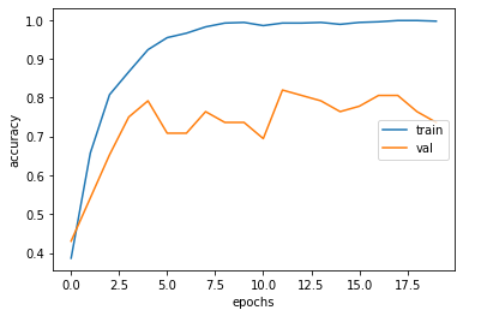  

2. 2 convolutions (16, 32):  
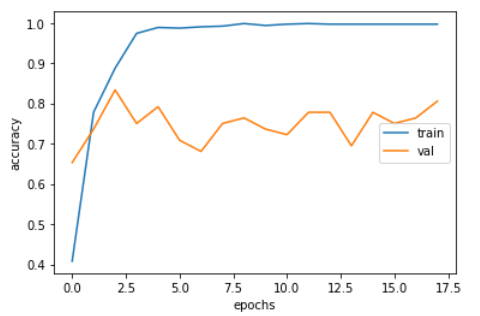  

3. 2 convolutions (32, 64):  
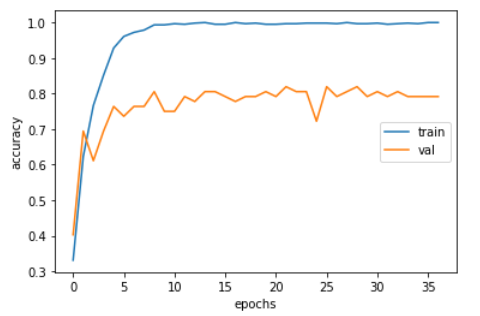  

4. 2 convolutions (8, 64):  
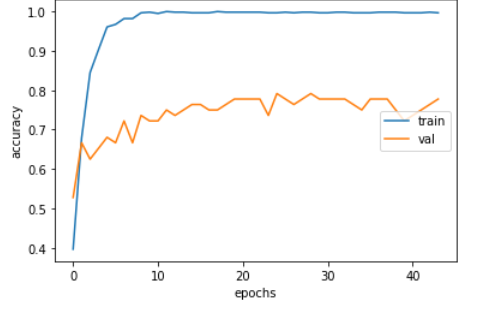

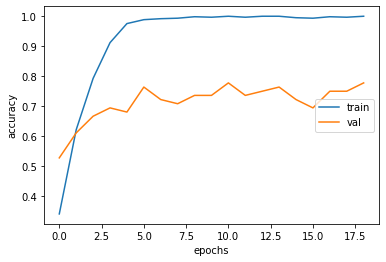

In [14]:
plt.plot(result.history['accuracy'], label = 'train',)
plt.plot(result.history['val_accuracy'], label = 'val')
plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

According to results illustrated we can say that the configuration (32, 64) is the best one.

## 4. Transfer Learning **RESNET50**

In many cases finding the right architecture and parameters configuration for your CNN model may take time and resources, and it's difficult to train the more deeper it gets, sometimes it might fall into vanishing or exploding gradient, overfitting ..etc. Residual learning framework present efficient solution with lower complexity and easly optimized for such problem. The idea consist of concatenating resudual block one after another [[1]](https://arxiv.org/abs/1512.03385) . A residual block is simply when the activation of a layer is fast-forwarded to a deeper layer in the neural network.  


![](https://qph.cf2.quoracdn.net/main-qimg-9ad7aa767f79084660a91c0b7cd3447e)

####  Model Configuration

In [15]:
IMAGE_SHAPE = (303, 430)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = IMAGE_SHAPE,
                                                   class_mode = 'categorical')

valid_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(val_directory,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = IMAGE_SHAPE,
                                                   class_mode = 'categorical')

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = IMAGE_SHAPE,
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [16]:
resnet_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', 
                     input_shape = (303,430, 3))


model = Sequential()
model.add(resnet_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,604,100
Trainable params: 23,546,884
N

In [17]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
checkpointer = ModelCheckpoint('./chest_CT_ResNet50.hdf5', monitor='val_loss', verbose = 1,save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [18]:
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 18s 624ms/step - loss: 2.6092 - accuracy: 0.2349 - val_loss: 1.3480 - val_accuracy: 0.3472

Epoch 00001: val_loss improved from inf to 1.34801, saving model to ./chest_CT_ResNet50.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
20/20 [==============================] - 10s 483ms/step - loss: 2.1481 - accuracy: 0.3263 - val_loss: 1.2104 - val_accuracy: 0.4167

Epoch 00002: val_loss improved from 1.34801 to 1.21044, saving model to ./chest_CT_ResNet50.hdf5
Epoch 3/100
20/20 [==============================] - 10s 509ms/step - loss: 1.6423 - accuracy: 0.4535 - val_loss: 1.1101 - val_accuracy: 0.4306

Epoch 00003: val_loss improved from 1.21044 to 1.11015, saving model to ./chest_CT_ResNet50.hdf5
Epoch 4/100
20/20 [==============================] - 10s 479ms/step - loss: 1.5536 - accuracy: 0.4861 - val_loss: 1.0592 - val_accuracy: 0.4028

Epoch 00004: val_loss improved from 1.11015 to 1.05917, saving model to ./chest_CT_ResNet50.hdf5
Epoch 5/100
20/20 [==============================] - 10s 492ms/step - loss: 1.3188 - accuracy: 0.5416 - val_loss: 1.0259 - val_accuracy: 0.4861

Epoch 00005: val_loss improved from 1.05917 to 1.02589, saving model to ./chest_CT_ResNet50.hdf5
Epoch 6/100
20/20 [=============

In [19]:
res_evaluation = model.evaluate(test_generator)

10/10 [==============================] - 4s 402ms/step - loss: 0.4206 - accuracy: 0.8730


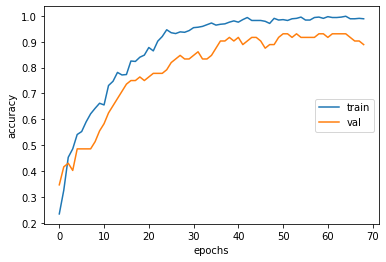

In [20]:
plt.plot(history_res.history['accuracy'], label = 'train',)
plt.plot(history_res.history['val_accuracy'], label = 'val')
plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()